# Load Data

In [1]:
# Load Data

import pandas as pd

tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'RTX', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]

# ticker of benchmark
benchmark = '^DJI'

# Get the data from the CSV files
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'../data/{ticker}.csv', index_col='Date', parse_dates=True)
    stock_data[ticker] = df


# Split into Training, Validation, and Testing

In [ ]:
# split the data into training, validation and test sets
training_data_time_range = ('2009-01-01', '2015-12-31') # 7 years = 1800 days
validation_data_time_range = ('2016-01-01', '2016-12-31') # 1 year
test_data_time_range = ('2017-01-01', '2020-05-08') # 3 years

In [3]:
# split the data into training, validation and test sets
training_data = {}
validation_data = {}
test_data = {}

# split the data dictionary into subdictionaries for training, validation, testing
for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# print shape of training, validation and test data
ticker = 'AAPL'
print(f'Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'Test data shape for {ticker}: {test_data[ticker].shape}')

# Display the first 5 rows of the data
stock_data['AAPL'].head()

Training data shape for AAPL: (1762, 6)
Validation data shape for AAPL: (252, 6)
Test data shape for AAPL: (843, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.733996,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.849381,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.802385,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.741829,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.792744,673500800


# Add Technical Indicators (add more)

In [4]:
import pandas as pd
import numpy as np

def add_technical_indicators(df):
    # MACD and Signal
    df.loc[:, 'EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df.loc[:, 'EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df.loc[:, 'MACD'] = df['EMA12'] - df['EMA26']
    df.loc[:, 'Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))
    
    # CCI
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())), raw=True)
    df.loc[:, 'CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
    
    # ADX
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df.loc[:, '+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df.loc[:, '-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df.loc[:, '+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df.loc[:, '-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df.loc[:, 'ADX'] = dx.ewm(span=14, adjust=False).mean()

    # Drop NaN values
    df.dropna(inplace=True)

    # Keep only the relevant columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df


Add TAs to dataset

In [5]:
# add technical indicators to the training data for each stock
for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)

# add technical indicators to the validation data for each stock
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)

# add technical indicators to the test data for each stock
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

# print the first 5 rows of the data

/var/folders/jy/j8xvywpn7mz4ylrqrpy4_1fm0000gn/T/ipykernel_83170/3116849229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
/var/folders/jy/j8xvywpn7mz4ylrqrpy4_1fm0000gn/T/ipykernel_83170/3116849229.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
/var/folders/jy/j8xvywpn7mz4ylrqrpy4_1fm0000gn/T/ipykernel_83170/3116849229.py:8: SettingWithCopyWarning: 
A value is tryi

In [6]:
print('Shape of training data for AAPL:', training_data['AAPL'].shape)
print('Shape of validation data for AAPL:', validation_data['AAPL'].shape)
print('Shape of test data for AAPL:', test_data['AAPL'].shape)

Shape of training data for AAPL: (1743, 10)
Shape of validation data for AAPL: (233, 10)
Shape of test data for AAPL: (824, 10)


In [7]:
training_data['AAPL'].head()

,Open,High,Low,Close,Volume,MACD,Signal,RSI,CCI,ADX
Date,,,,,,,,,,
2009-01-30,3.307143,3.343571,3.214643,3.218929,651478800,0.006402,-0.021685,49.306651,47.902378,37.074715
2009-02-02,3.182143,3.285714,3.175000,3.268214,558247200,0.011944,-0.014959,54.465651,36.606061,34.087952
2009-02-03,3.282857,3.335000,3.224286,3.320714,599309200,0.020337,-0.007900,58.125186,67.371041,31.499425
2009-02-04,3.329286,3.437500,3.325000,3.341071,808421600,0.028306,-0.000659,63.422589,107.921132,32.708435
2009-02-05,3.313214,3.473214,3.307857,3.445000,749246400,0.042517,0.007976,70.709311,120.258075,34.617904


# Create the Trading Env

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, stock_data, transaction_cost_percent=0.005):
        super(StockTradingEnv, self).__init__()
        
        # Remove any empty DataFrames
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())
        
        
        # Calculate the size of one stock's data
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns) # number of features for each stock (i.e price and TAs)
        
        # Define action and observation space
        """
        This line defines a continuous action space where:

        Each element represents an action on a specific ticker.
        Each action is constrained between -1 (sell) and 1 (buy).
        The action space size matches the number of tickers (len(self.tickers)), 
        and each action can independently take a continuous value within the defined range.
        """
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)
        
        # Observation space: price data for each stock + balance + shares held + net worth + max net worth + current step
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        # values in the observations space can take on values in the continuous range (-inf, inf). Each observation is a long vector containig all the values in the space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        # Initialize account balance
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        # Set the current step
        self.current_step = 0
        
        # Calculate the minimum length of data across all stocks
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)
        # max steps is basically the length of our dataset - each day is a step

        # Transaction cost
        self.transaction_cost_percent = transaction_cost_percent
    
    def reset(self, seed=None, options=None):
        """
        Reset the environment back to the start
        """
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        # initialize the frame
        frame = np.zeros(self.obs_shape) # empty observation vector
        
        # Add stock data for each ticker
        idx = 0
        # Loop through each ticker
        for ticker in self.tickers:
            # Get the DataFrame for the current ticker
            df = self.stock_data[ticker]
            # If the current step is less than the length of the DataFrame, add the price data for the current step
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            # Otherwise, add the last price data available
            elif len(df) > 0:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            # Move the index to the next ticker
            idx += self.n_features
        
        # This look [features for stock1, features for stock2]

        # Add balance, shares held, net worth, max net worth, and current step
        frame[-4-len(self.tickers)] = self.balance # Balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers] # Shares held
        frame[-3] = self.net_worth # Net worth
        frame[-2] = self.max_net_worth # Max net worth
        frame[-1] = self.current_step # Current step

        # Adds these observations to the end of the observation vector
        
        return frame
    
    def step(self, actions):
        # update the current step
        self.current_step += 1
        
        # check if we have reached the maximum number of steps
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}
        
        current_prices = {}
        # Loop through each ticker and perform the action
        for i, ticker in enumerate(self.tickers):
            # Get the current price of the stock
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
            # get the action for the current ticker
            action = actions[i]
            
            if action > 0:  # Buy
                # Calculate the number of shares to buy
                # shares to buy is proportion of balance / current_price
                # spend some portion of your balance on buying shares, action is the portion of your balance to spend
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                # Calculate the cost of the shares
                cost = shares_to_buy * current_prices[ticker]
                # Transaction cost
                transaction_cost = cost * self.transaction_cost_percent
                # Update the balance and shares held
                self.balance -= (cost + transaction_cost)
                # Update the total shares sold
                self.shares_held[ticker] += shares_to_buy

            elif action < 0:  # Sell
                # Calculate the number of shares to sell
                # sell x percentage of your shares for this stock
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                # Calculate the sale value
                sale = shares_to_sell * current_prices[ticker]
                # Transaction cost
                transaction_cost = sale * self.transaction_cost_percent
                # Update the balance and shares held
                self.balance += (sale - transaction_cost)
                # Update the total shares sold
                self.shares_held[ticker] -= shares_to_sell
                # Update the shares sold
                self.total_shares_sold[ticker] += shares_to_sell
                # Update the total sales value
                self.total_sales_value[ticker] += sale
        
        # Calculate the net worth
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        # Update the max net worth
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        # Calculate the reward
        # the reward is just networth so far
        reward = self.net_worth - self.initial_balance
        # Check if the episode is done
        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        
        obs = self._next_observation()
        return obs, reward, done, False, {}
    
    def render(self, mode='human'):
        # Print the current step, balance, shares held, net worth, and profit
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')

    def close(self):
        pass

    def update_stock_data(self, new_stock_data, transaction_cost_percent=None):
        """
        Update the environment with new stock data.

        Parameters:
        new_stock_data (dict): Dictionary containing new stock data,
                            with keys as stock tickers and values as DataFrames.
        """
        # Remove empty DataFrames
        self.stock_data = {ticker: df for ticker, df in new_stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All new stock data are empty")

        # Update the number of features if needed
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # Update observation space
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        # Update maximum steps
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # Update transaction cost if provided
        if transaction_cost_percent is not None:
            self.transaction_cost_percent = transaction_cost_percent

        # Reset the environment
        self.reset()

        print(f"The environment has been updated with {len(self.tickers)} new stocks.")

# Train the Model - PPO Agent

In [22]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv

# Define Ensemble Agent
class EnsembleAgent:
    def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
        self.sac_model = sac_model
        self.td3_model = td3_model
    
    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs)
        a2c_action, _ = self.a2c_model.predict(obs)
        ddpg_action, _ = self.ddpg_model.predict(obs)
        sac_action, _ = self.sac_model.predict(obs)
        td3_action, _ = self.td3_model.predict(obs)
        
        # Average the actions
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis=0)
        return ensemble_action
    
# Define PPO Agent
class PPOAgent:
    def __init__(self, env, total_timesteps):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define A2C Agent
class A2CAgent:
    def __init__(self, env, total_timesteps):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define DDPG Agent
class DDPGAgent:
    def __init__(self, env, total_timesteps):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
     
# Define SAC Agent
class SACAgent:
    def __init__(self, env, total_timesteps):
        self.model = SAC("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define TD3 Agent
class TD3Agent:
    def __init__(self, env, total_timesteps):
        self.model = TD3("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create the environment and train the agents
def create_env_and_train_agents(data, total_timesteps):
    # Create the environment using DummyVecEnv with training data
    env = DummyVecEnv([lambda: StockTradingEnv(data)])

    # Train PPO Agent
    #ppo_agent = PPOAgent(env, total_timesteps)

    # Train A2C Agent
    #a2c_agent = A2CAgent(env, total_timesteps)

    # Train DDPG Agent
    ddpg_agent = DDPGAgent(env, total_timesteps)

    # Train SAC Agent
    #sac_agent = SACAgent(env, total_timesteps)

    # Train TD3 Agent
    #td3_agent = TD3Agent(env, total_timesteps)

    # Train the ensemble agent
    #ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model, sac_agent.model, td3_agent.model)

    #return env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent
    return env, ddpg_agent

Functions to visualize progress

In [24]:
import matplotlib.pyplot as plt

# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()


# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

Function to test agent

In [25]:
def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    Test a single agent and track performance metrics, with an option to visualize the results.

    Parameters:
    - env: The trading environment.
    - agent: The agent to be tested.
    - stock_data: Data for the stocks in the environment.
    - n_tests: Number of tests to run (default: 1000). This is the total number of steps you take on the environment
    - visualize: Boolean flag to enable or disable visualization (default: False).

    Returns:
    - A dictionary containing steps, balances, net worths, and shares held.
    """
    # Initialize metrics tracking
    metrics = {
        'steps': [], # steps?
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # Reset the environment before starting the tests
    obs = env.reset()

    # Is one iteration a day?
    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, rewards, dones, infos = env.step(action)
        if visualize:
            env.render()

        # Track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # Update shares held for each ticker
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # Append 0 if ticker is not found

        if dones:
            obs = env.reset()
            
    return metrics

Function for testing all agents

In [26]:
# If n_tests is 1000 bays but our training data is 6 years, are we even using all the training data

def test_and_visualize_agents(env, agents, training_data, n_tests=1000):
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, training_data, n_tests=n_tests, visualize=True)
        print(f"Done testing {agent_name}!")
    
    print('-'*50)
    print('All agents tested!')
    print('-'*50)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

Function to compare the performance of agents

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0.0):
    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:
            net_worths = metrics['net_worths']
            # Calculate daily returns
            daily_returns = np.diff(net_worths) / net_worths[:-1]
            avg_return = np.mean(daily_returns)
            std_return = np.std(daily_returns)
            sharpe_ratio = (avg_return - risk_free_rate) / std_return

            returns.append(avg_return)
            stds.append(std_return)
            sharpe_ratios.append(sharpe_ratio)

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)
    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

Using cpu device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 78        |
|    time_elapsed    | 89        |
|    total_timesteps | 6968      |
| train/             |           |
|    actor_loss      | -4.26e+05 |
|    critic_loss     | 6.28e+09  |
|    learning_rate   | 0.001     |
|    n_updates       | 6867      |
----------------------------------
Testing DDPG Agent...


/Users/evanzimmerman/Github_Repos/Reinforcement-Learning-Stock-Trading-Bot-/myenv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing DDPG Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


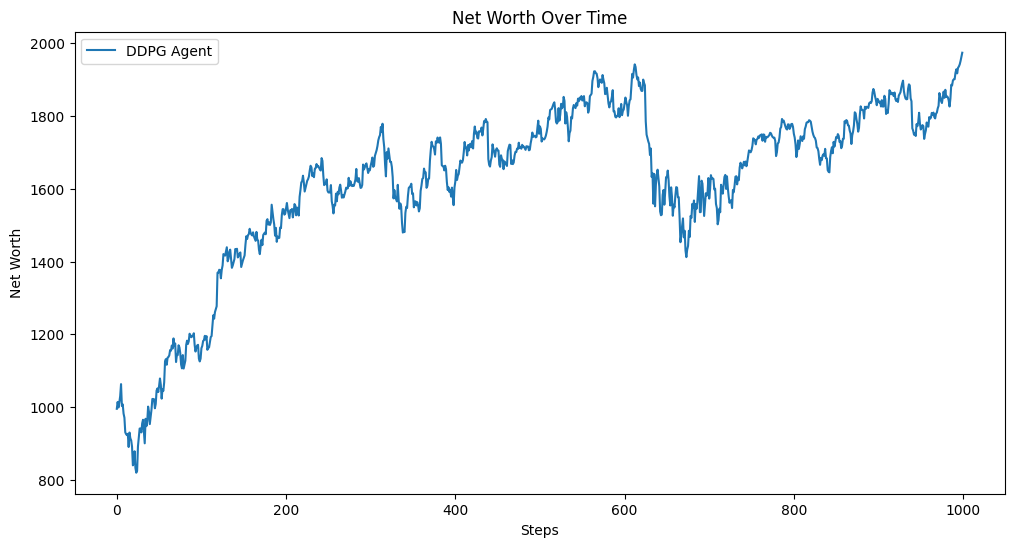

In [28]:
# 1. Create the environment and train the agents
total_timesteps = 10000 # 10,000 days of training
#env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent, sac_agent, td3_agent = create_env_and_train_agents(training_data, total_timesteps)
env, ddpg_agent = create_env_and_train_agents(training_data, total_timesteps)

# 2. Test & visualize the agents
n_tests = 1000 # 1,000 days of testing
agents = {
    #'PPO Agent': ppo_agent,
    #'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    #'Ensemble Agent': ensemble_agent, 
    #'SAC Agent': sac_agent,
    #'TD3 Agent': td3_agent
}
test_and_visualize_agents(env, agents, training_data, n_tests=n_tests)

Testing DDPG Agent...
Done testing DDPG Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


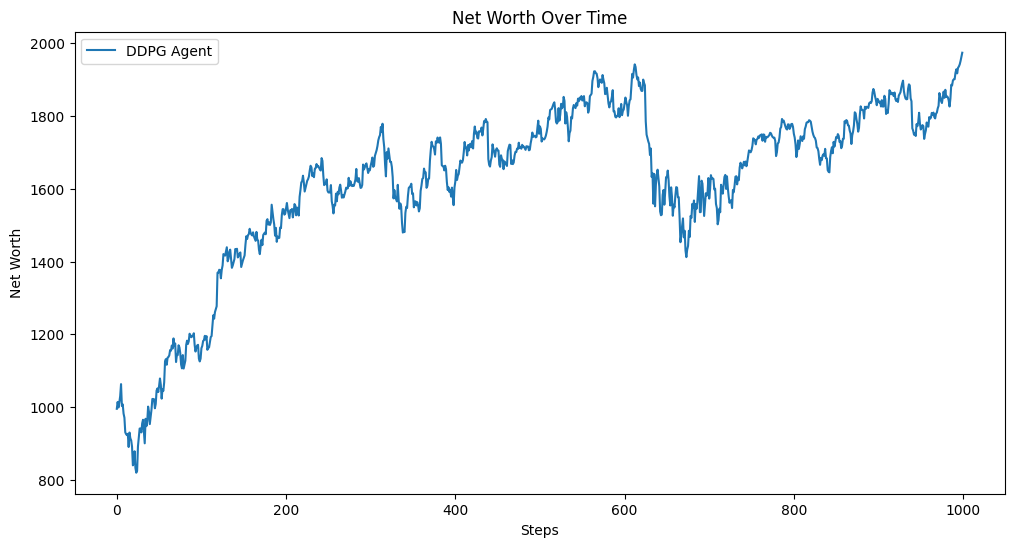

,Agent,Return,Standard Deviation,Sharpe Ratio
0,DDPG Agent,0.0008,0.015101,0.05298


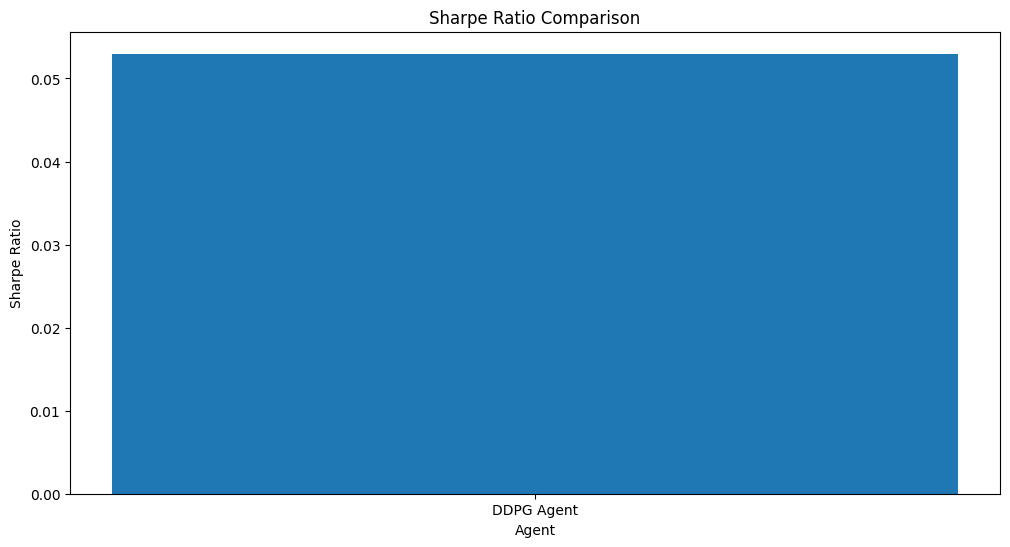

In [29]:
# Create the environment using DummyVecEnv with test data
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

# 2. Test & visualize the agents on the test data
n_tests = 1000
test_agents = {
    #'PPO Agent': ppo_agent,
    #'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    #'Ensemble Agent': ensemble_agent,
    #'SAC Agent': sac_agent,
    #'TD3 Agent': td3_agent
}
test_and_visualize_agents(env, test_agents, test_data, n_tests=n_tests)

# 3. Compare the agents' performance on the test data ( returns, standard deviation, and sharpe ratio )
test_agents_metrics = [test_agent(env, agent, test_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))